# Machine Learning Portfolio 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

from scipy.fft import fft, ifft
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
df_train = pd.read_csv("train.csv", parse_dates=['date_hour'])
df_test = pd.read_csv("test.csv", parse_dates=['date_hour'])
sample = pd.read_csv("sample_submission.csv")

In [12]:
agg_dict = {'holiday': np.mean, 'weathersit': np.mean, 'temp': np.mean, 
            'hum': np.mean, 'windspeed': np.mean, 'cnt':np.sum}
models_dict = {'lr': [ LinearRegression(), {} ],
               'dt': [ DecisionTreeRegressor(), {"criterion":["squared_error", "friedman_mse", "absolute_error", "poisson"],
                                                 "splitter":["best", "random"],
                                                 "max_depth":[30,35]} ],
               'rf': [ RandomForestRegressor(random_state=42, n_jobs=-1), {"criterion":["squared_error", "absolute_error", "friedman_mse", "poisson"],
                                                                           "max_depth": [30,35]} ],
               'gb': [ GradientBoostingRegressor(random_state=42), {"loss":["squared_error","absolute_error","huber","quantile"],
                                                                    "criterion":["friedman_mse","squared_error"],
                                                                    "max_depth":[30,35],
                                                                    "learning_rate":[0,0.01,0.1,1]} ],
               'ada': [ AdaBoostRegressor(random_state=42), {"base_estimator":[DecisionTreeRegressor(criterion='poisson', max_depth=35, splitter='random')],
                                                             "loss":["linear","square","exponential"],
                                                             "learning_rate":[0,0.01,0.1,1]} ]
              }

In [13]:
class date_time_resample:
    def __init__(self, data, agg_dict=agg_dict):
        self.dfh = data.set_index('date_hour')
        self.dfh.resample('H').agg(agg_dict)
        self.dfh = self.dfh.reset_index()
        self.dfh["Year"] = self.dfh["date_hour"].dt.year
        self.dfh["Month"] = self.dfh["date_hour"].dt.month
        self.dfh["Day_of_Week"] = self.dfh["date_hour"].dt.dayofweek
        self.dfh["Day_name"] = self.dfh["date_hour"].dt.day_name()
        self.dfh["Hour"] = self.dfh["date_hour"].dt.hour
        self.dfh["Week"] = self.dfh["date_hour"].dt.isocalendar().week
        self.dfh.set_index('date_hour', inplace=True)
        
        
class RegressionModels:
    def __init__(self, data, target, dummie_cols=False, shuffle=True, test_size=0.2, random_state=42):
        self.data = data
        if dummie_cols:
            self.data = pd.get_dummies(self.data, columns=dummie_cols)              
        self.X = self.data.drop(target, axis=1)
        self.y = self.data[[target]]        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y,
                                                                                test_size=test_size, shuffle=shuffle, 
                                                                                random_state=random_state)
        
    def time_series_data(self, order, constant=False, drop=True):
        dp = DeterministicProcess(index=self.y_train.index, constant=constant, order=order, drop=drop)
        self.X_train2 = dp.in_sample()
        self.X_test2 = dp.out_of_sample(steps=len(self.y_test), forecast_index=self.y_test.index)
        
    def concat_data(self):
        self.X_train = pd.concat([self.X_train, self.X_train2], axis=1)
        self.X_test = pd.concat([self.X_test, self.X_test2], axis=1)
        
    def tune_params(self, n_splits, models_dict=models_dict):
        self.models_dict = models_dict
        self.results = {}
        self.best_model = None
        self.best_params = None
        self.best_score = 0
        kf = TimeSeriesSplit(n_splits=n_splits)
        for model in models_dict.items():
            model_cv = GridSearchCV(estimator=model[1][0], param_grid=model[1][1], cv=kf, n_jobs=-1)
            model_cv.fit(self.X_train, self.y_train)
            self.results[model[0]] = [model_cv.best_params_, model_cv.best_score_]
            print(model[0], self.results[model[0]])
            if model_cv.best_score_ > self.best_score:
                self.best_score = model_cv.best_score_
                self.best_model = model[0]
                self.best_params = model_cv.best_params_   
        
    def predict(self):
        # dict to store feature importances
        self.fi = {}
        self.model = self.models_dict[self.best_model][0].set_params(**self.best_params)
        print('fit_predict',self.model)
        self.model.fit(self.X_train, self.y_train)
        self.y_test_pred = self.model.predict(self.X_test)
        self.y_train_pred = self.model.predict(self.X_train)
        print(f'train r2 {self.model}', r2_score(self.y_train, self.y_train_pred))
        print(f'test r2 {self.model}', r2_score(self.y_test, self.y_test_pred))
        # only if attribute exists
        if hasattr (self.model, 'feature_importances_'):
                self.fi[self.best_model] = self.model.feature_importances_
                
    def show_feature_importances(self):
        for fi in self.fi.items():
            feature_importance = pd.DataFrame(fi[1])
            cols = pd.DataFrame(self.X_train.columns)
            df_fi = pd.concat([cols, feature_importance], axis=1)
            df_fi.columns = ['feature', 'importance']
            df_fi.sort_values('importance', ascending=True, inplace=True)
            df_fi.plot(kind='barh', x='feature', y='importance', title=fi[0])

In [14]:
train = date_time_resample(data=df_train)
train.dfh

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Year,Month,Day_of_Week,Day_name,Hour,Week
date_hour,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0000,16,2011,1,5,Saturday,0,52
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0000,40,2011,1,5,Saturday,1,52
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0000,32,2011,1,5,Saturday,2,52
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0000,13,2011,1,5,Saturday,3,52
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0000,1,2011,1,5,Saturday,4,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-30 19:00:00,0,1,0.32,0.3485,0.66,0.0000,377,2012,11,4,Friday,19,48
2012-11-30 20:00:00,0,1,0.32,0.3485,0.66,0.0000,245,2012,11,4,Friday,20,48
2012-11-30 21:00:00,0,1,0.30,0.3182,0.75,0.0896,183,2012,11,4,Friday,21,48


In [15]:
data = RegressionModels(data=train.dfh, dummie_cols=['Hour', 'Day_name'], target='cnt', shuffle=False, test_size=7*24)
data.time_series_data(order=1)
data.concat_data()
data.tune_params(n_splits=52, models_dict=models_dict)
print(data.results, data.best_model, data.best_score, data.best_params)
data.predict()
data.show_feature_importances()

lr [{}, -1216547537183983.0]
dt [{'criterion': 'poisson', 'max_depth': 35, 'splitter': 'random'}, 0.7064678395604065]


C:\Anaconda\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


rf [{'criterion': 'poisson', 'max_depth': 30}, 0.8017467435254814]


C:\Anaconda\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


gb [{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 30}, 0.7692230342147346]


C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ada [{'base_estimator': DecisionTreeRegressor(criterion='poisson', max_depth=35, splitter='random'), 'loss': 'linear'}, 0.8413433080561201]
{'lr': [{}, -1216547537183983.0], 'dt': [{'criterion': 'poisson', 'max_depth': 35, 'splitter': 'random'}, 0.7064678395604065], 'rf': [{'criterion': 'poisson', 'max_depth': 30}, 0.8017467435254814], 'gb': [{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 30}, 0.7692230342147346], 'ada': [{'base_estimator': DecisionTreeRegressor(criterion='poisson', max_depth=35, splitter='random'), 'loss': 'linear'}, 0.8413433080561201]} ada 0.8413433080561201 {'base_estimator': DecisionTreeRegressor(criterion='poisson', max_depth=35, splitter='random'), 'loss': 'linear'}
fit_predict AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='poisson',
                                                       max_depth=35,
                                                       splitter='random'),
                  random_

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


train r2 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='poisson',
                                                       max_depth=35,
                                                       splitter='random'),
                  random_state=42) 0.9997649232885139
test r2 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='poisson',
                                                       max_depth=35,
                                                       splitter='random'),
                  random_state=42) 0.7711604120838678


AttributeError: 'RegressionModels' object has no attribute 'feature_imp'

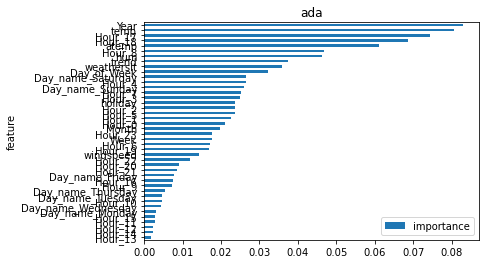

In [16]:
data.show_feature_importances()

In [ ]:
# lr [{}, -1216547537183983.0]
# dt [{'criterion': 'poisson', 'max_depth': 35, 'splitter': 'random'}, 0.7064678395604065]
# rf [{'criterion': 'poisson', 'max_depth': 30}, 0.8017467435254814]
# gb [{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 30}, 0.7692230342147346]
# ada [{'base_estimator': DecisionTreeRegressor(criterion='poisson', max_depth=35, splitter='random'), 'loss': 'linear'}, 0.8413433080561201]
# 

In [ ]:
# {'lr': [{}, -1216547537183983.0], 'dt': [{'criterion': 'poisson', 'max_depth': 35, 'splitter': 'random'}, 0.7064678395604065], 'rf': [{'criterion': 'poisson', 'max_depth': 30}, 0.8017467435254814], 'gb': [{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_depth': 30}, 0.7692230342147346], 'ada': [{'base_estimator': DecisionTreeRegressor(criterion='poisson', max_depth=35, splitter='random'), 'loss': 'linear'}, 0.8413433080561201]} ada 0.8413433080561201 {'base_estimator': DecisionTreeRegressor(criterion='poisson', max_depth=35, splitter='random'), 'loss': 'linear'}
# fit_predict AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='poisson',
#                                                        max_depth=35,
#                                                        splitter='random'),
#                   random_state=42)

In [ ]:
# train r2 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='poisson',
#                                                        max_depth=35,
#                                                        splitter='random'),
#                   random_state=42) 0.9997649232885139
# test r2 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='poisson',
#                                                        max_depth=35,
#                                                        splitter='random'),
#                   random_state=42) 0.7711604120838678

## EDA

In [18]:
display(train.dfh.info(), train.dfh.describe(), train.dfh.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16637 entries, 2011-01-01 00:00:00 to 2012-11-30 23:00:00
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   holiday      16637 non-null  int64  
 1   weathersit   16637 non-null  int64  
 2   temp         16637 non-null  float64
 3   atemp        16637 non-null  float64
 4   hum          16637 non-null  float64
 5   windspeed    16637 non-null  float64
 6   cnt          16637 non-null  int64  
 7   Year         16637 non-null  int64  
 8   Month        16637 non-null  int64  
 9   Day_of_Week  16637 non-null  int64  
 10  Day_name     16637 non-null  object 
 11  Hour         16637 non-null  int64  
 12  Week         16637 non-null  UInt32 
dtypes: UInt32(1), float64(4), int64(7), object(1)
memory usage: 1.7+ MB


None

,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Year,Month,Day_of_Week,Hour,Week
count,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000,16637.000000
mean,0.028671,1.415580,0.504745,0.482608,0.624756,0.190310,190.477009,2011.480375,6.294164,3.008776,11.547875,25.614895
std,0.166885,0.637298,0.192369,0.171557,0.193227,0.121915,182.026755,0.499630,3.310969,1.998538,6.914199,14.466678
min,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.340000,0.333300,0.470000,0.104500,41.000000,2011.000000,3.000000,1.000000,6.000000,13.000000
50%,0.000000,1.000000,0.520000,0.500000,0.620000,0.194000,143.000000,2011.000000,6.000000,3.000000,12.000000,26.000000
75%,0.000000,2.000000,0.660000,0.621200,0.780000,0.253700,282.000000,2012.000000,9.000000,5.000000,18.000000,38.000000
max,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,977.000000,2012.000000,12.000000,6.000000,23.000000,52.000000


,holiday,weathersit,temp,atemp,hum,windspeed,cnt,Year,Month,Day_of_Week,Day_name,Hour,Week
date_hour,,,,,,,,,,,,,
2011-01-01 00:00:00,0,1,0.24,0.2879,0.81,0.0,16,2011,1,5,Saturday,0,52
2011-01-01 01:00:00,0,1,0.22,0.2727,0.80,0.0,40,2011,1,5,Saturday,1,52
2011-01-01 02:00:00,0,1,0.22,0.2727,0.80,0.0,32,2011,1,5,Saturday,2,52
2011-01-01 03:00:00,0,1,0.24,0.2879,0.75,0.0,13,2011,1,5,Saturday,3,52
2011-01-01 04:00:00,0,1,0.24,0.2879,0.75,0.0,1,2011,1,5,Saturday,4,52


- date_hour: Je hebt informatie over de periode van 1-1-2011 t/m 30-11-2012
- holiday: Vakantiedag of geen vakantiedag
- weathersit: Weersituatie:
    1. Helder, licht bewolkt, deels bewolkt
    2. Mistig , mistig en licht bewolkt
    3. Lichte sneeuw, lichte regen, lichte regen en onweer, zwaar bewolkt, lichte regen en zwaar bewolkt
    4. Zware regen, hagel, zware mist, sneeuw.
- temp: genormaliseerde temperatuur
- atemp: genormaliseerde gevoelstemperatuur
- hum: genormaliseerde luchtvochtigheid
- windspeed: genormaliseerde windsnelheid.

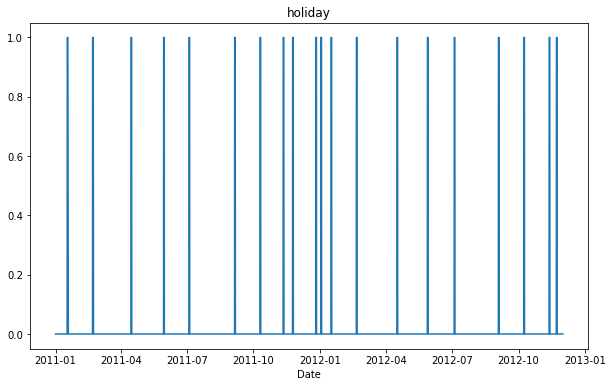

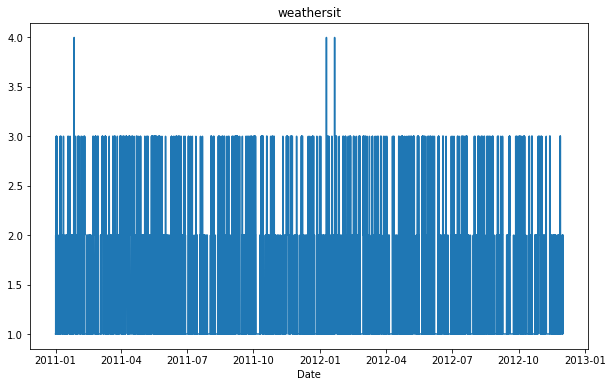

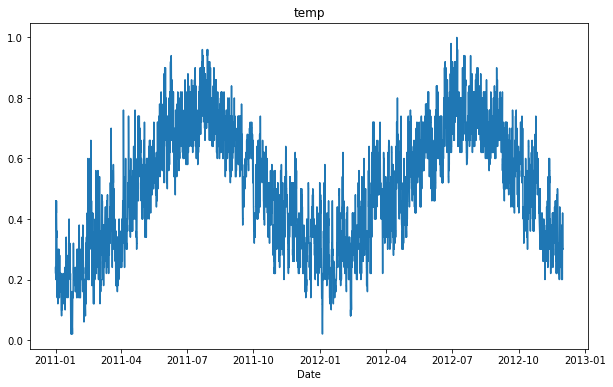

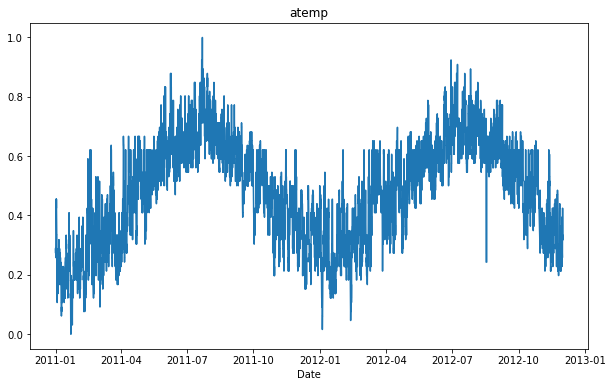

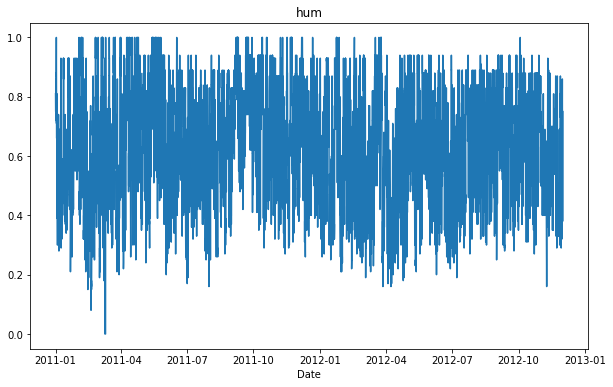

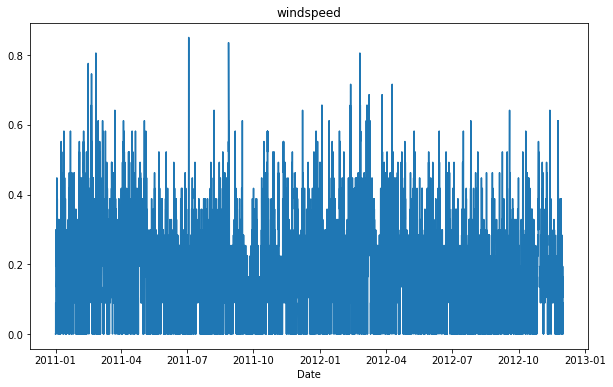

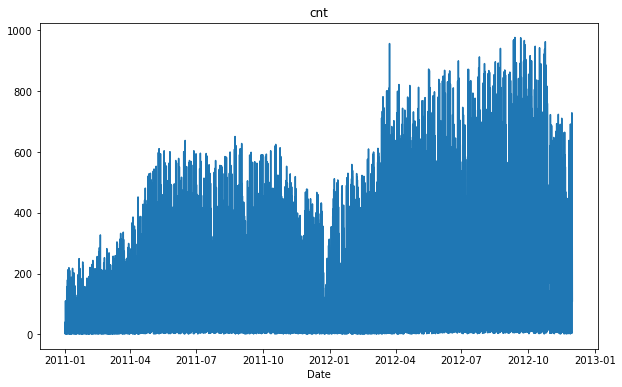

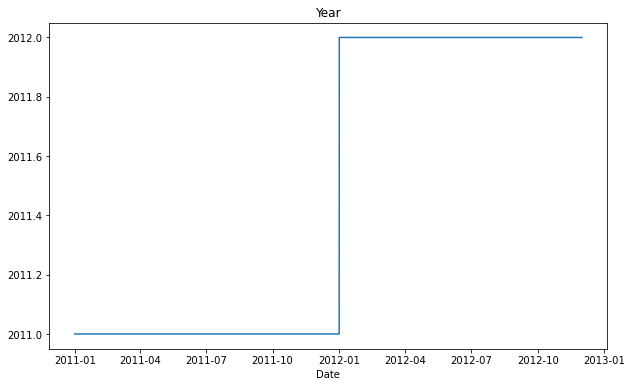

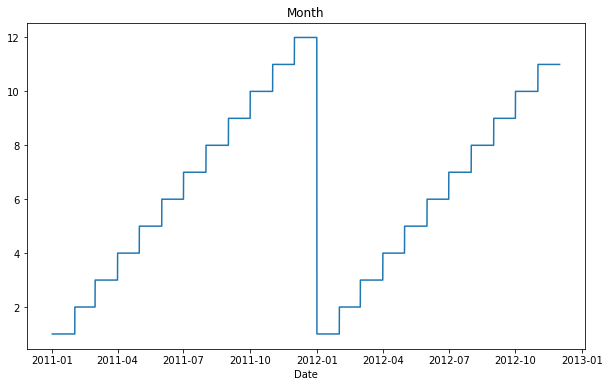

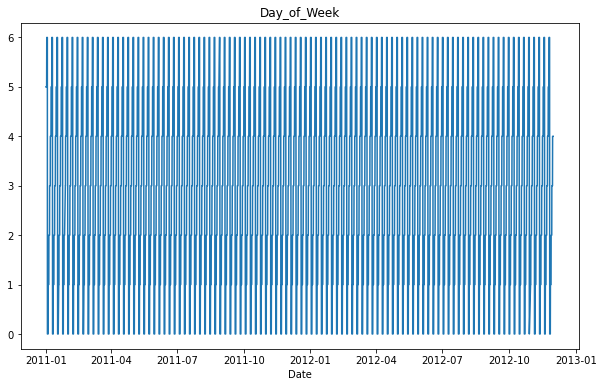

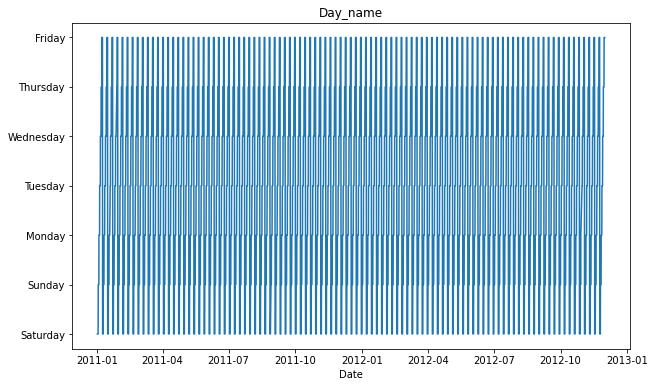

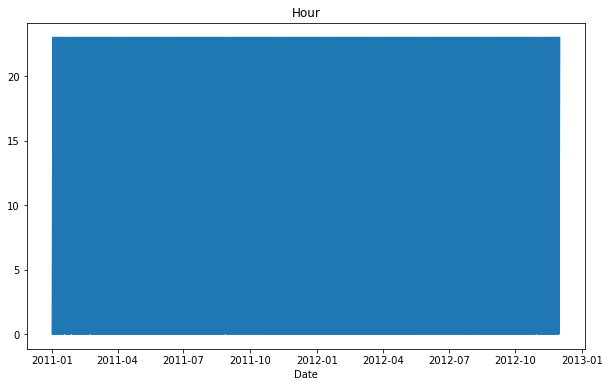

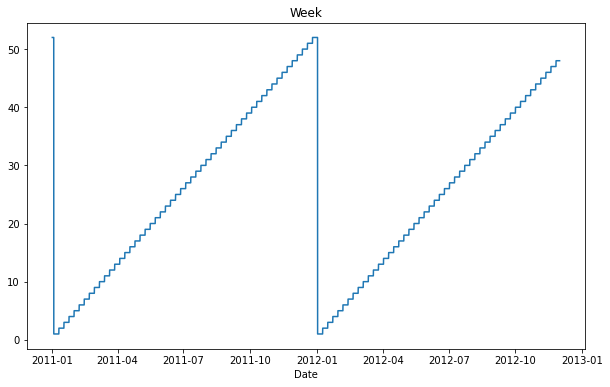

In [23]:
for col in train.dfh.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(train.dfh.index, train.dfh[col])
    plt.title(col)
    plt.xlabel('Date')
    plt.show()

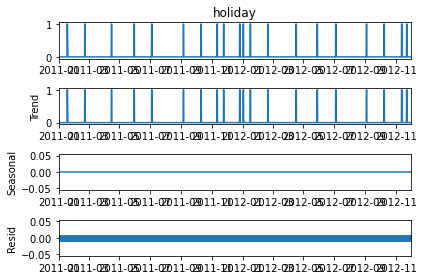

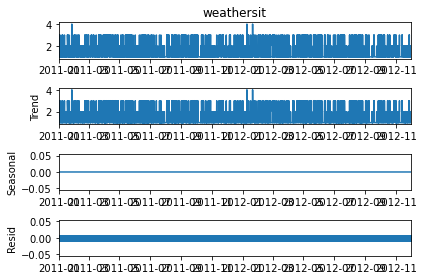

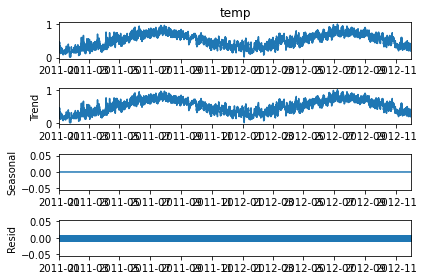

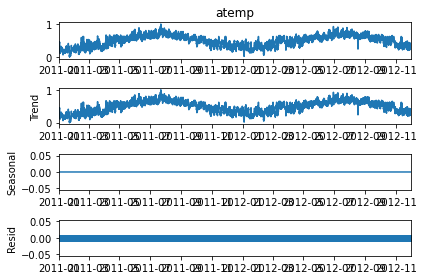

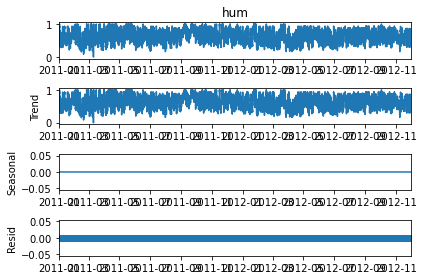

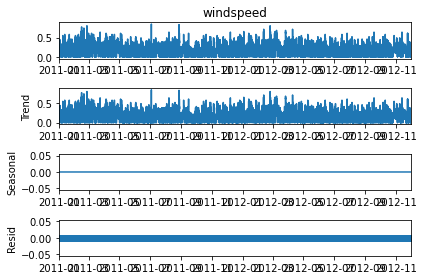

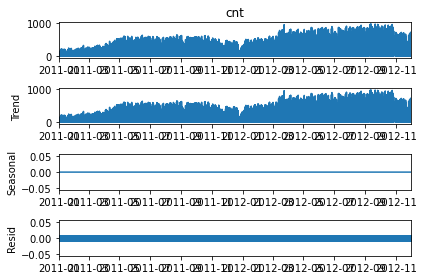

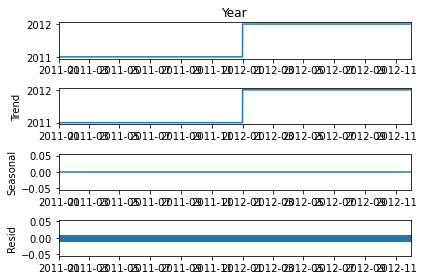

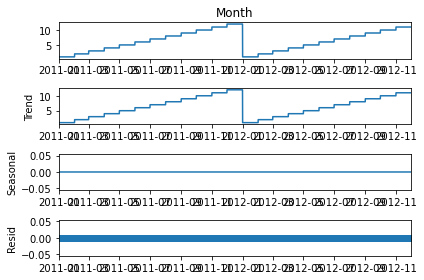

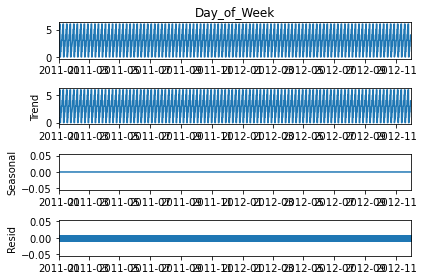

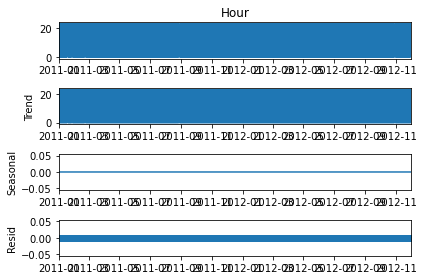

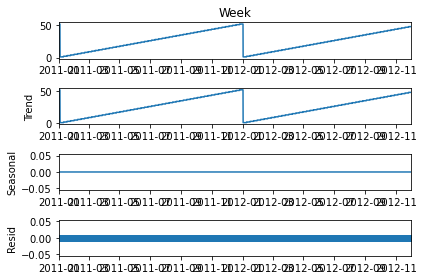

In [40]:
for col in train.dfh.columns.drop('Day_name'):
    result = seasonal_decompose(train.dfh[col], model='additive', period=1)
    result.plot()
    plt.show()

holiday       -0.026586
weathersit    -0.140111
temp           0.409245
atemp          0.404820
hum           -0.327288
windspeed      0.097006
cnt            1.000000
Year           0.266739
Month          0.140023
Day_of_Week   -0.002969
Hour           0.396945
Week           0.130888
Name: cnt, dtype: float64


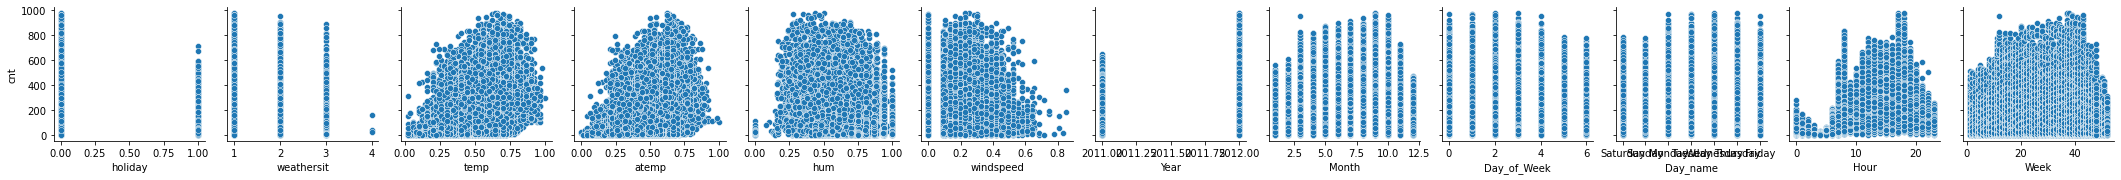

In [41]:
print(train.dfh.corr()['cnt'])

x_cols = train.dfh.columns.drop('cnt')
y_col = 'cnt'
fig = sns.pairplot(
    train.dfh,
    x_vars=x_cols,
    y_vars=y_col
)
plt.show()

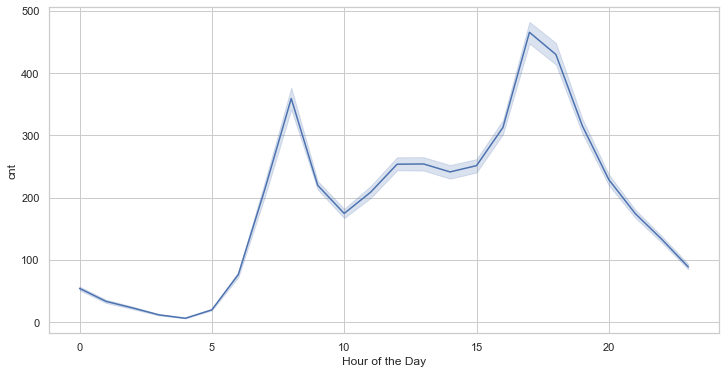

In [42]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Hour", y="cnt")
# plt.title()
plt.xlabel("Hour of the Day")
# plt.ylabel()
plt.show()

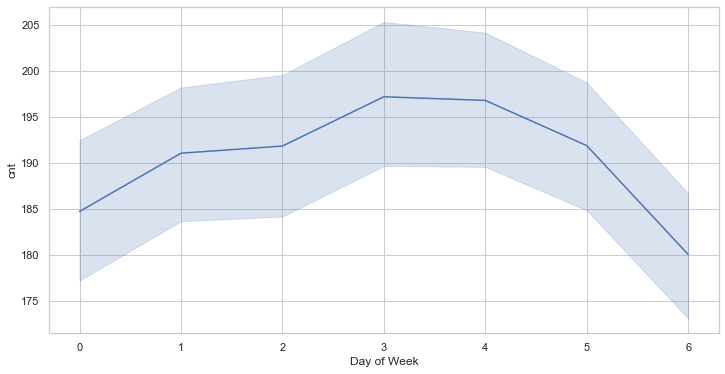

In [43]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Day_of_Week", y="cnt")
# plt.title()
plt.xlabel("Day of Week")
# plt.ylabel()
plt.show()

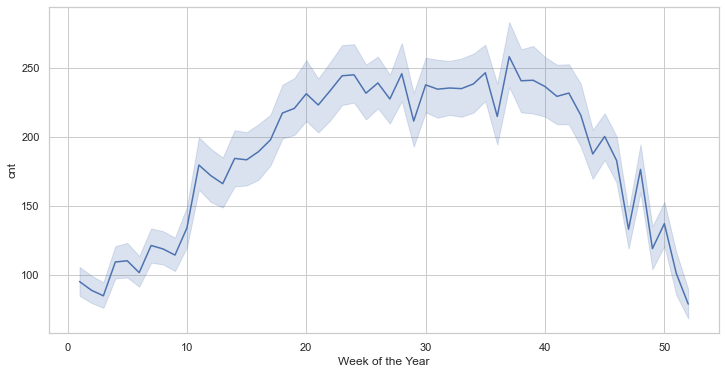

In [44]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Week", y="cnt")
# plt.title()
plt.xlabel("Week of the Year")
# plt.ylabel()
plt.show()

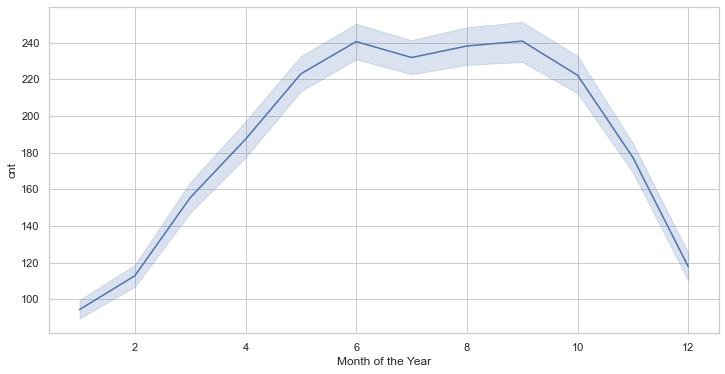

In [45]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=train.dfh, x="Month", y="cnt")
# plt.title()
plt.xlabel("Month of the Year")
# plt.ylabel()
plt.show()

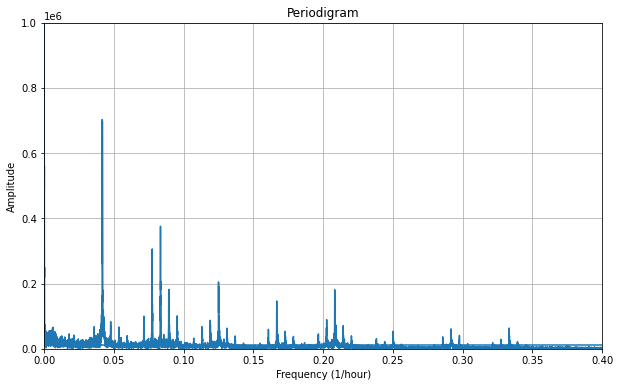

In [39]:
tijdreeks = train.dfh['cnt']
n = len(tijdreeks)
freq = np.fft.fftfreq(n,1)
fft_result = fft(tijdreeks)

plt.figure(figsize=(10, 6))
plt.plot(freq, np.abs(fft_result))
plt.xlabel('Frequency (1/hour)')
plt.ylabel('Amplitude')
plt.xlim([0,0.4])
plt.ylim([0,1e6])
plt.title('Periodigram')
plt.grid(True)
plt.show()